# Purpose
This example demonstrates how to access method results in Dakota's HDF5 output. Specifically, the univariate effects computed by a centered parameter study are plotted. In addition to numerical results, metadata (response labels) are extracted from a dimension scale on a dataset. Complete details about the organization of results and evaluation data in Dakota's HDF5 output are available in the [Reference Manual](https://dakota.sandia.gov/content/latest-reference-manual). The [h5py](https://www.h5py.org/) documentation is also a valuable resource.

## Study Details

The simulation that Dakota runs is a simple analytical model of a cantilever beam. The variables studied are:

* **R**: yield strength
* **E**: Young's modulus
* **X**: horizontal load
* **Y**: vertical load
* **w**: width
* **t**: thickness

The length and other pertinent material properties of the beam are fixed.

The responses are the cross-sectional **area** of the beam, the **stress**, and the tip **displacement**.

To (re)generate the results output (dakota_results.h5), run dakota -i dakota_centered.in.

## Plotting Strategy
A separate plot will be produced for each of the three responses--area, stress, and displacement--that shows the univariate effects of all the variables. To put the variables on a common axis, the responses will be plotted versus step index, from -5 to 5.

In the results file, the method results group `/methods/NO_METHOD_ID/results/execution:1` contains a group named `variable_slices`, and `variable_slices` contains one subgroup per variable. Within these subgroups, there are two datasets:

* `steps`: The univariate steps for the variable, including the center point
* `responses`: A 2D dataset for all the responses, including the center point

(Examining the results of a centered parameter study by using the `variable_slices` datasets in the HDF5 output is simpler than using Dakota's tabular output inasmuch as the center point is repeated.)

Because the data are grouped by variable rather than by response, we'll have to iterate over the groups repeatedly for each response.

The approach is:
1. Open the Dakota results file in read-only mode using the `h5py.File()` method.
2. Iterate over the response labels
3. For each response, iterate over the variable groups to obtain the response values.
4. Plot the response values versus the step indexes.

---
Begin by importing `h5py` and other required modules.

In [1]:
from __future__ import print_function
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt

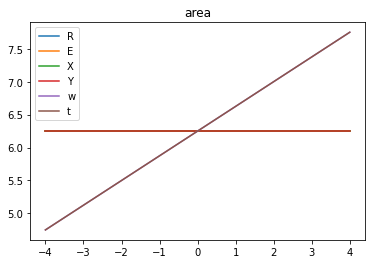

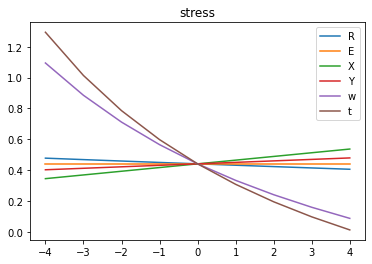

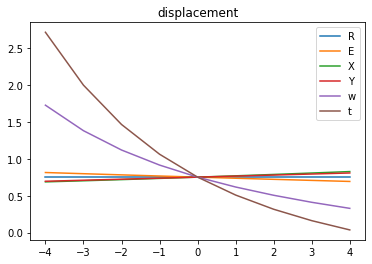

In [2]:
# Use a context manager (i.e. "with") to ensure the file is closed properly in case of errors
with h5py.File("dakota_results.h5","r") as h:
    # For convenience, create a Group object
    # that refers to the results we are interested in.
    results = h["/methods/NO_METHOD_ID/results/execution:1/"]
    
    ### iterate over the response labels ##
    # We need the response descriptors. We could get them from the dimension scale on 
    # variable_slices/<some variable>/responses, but they are also available from 
    # parameter_sets/responses, and in that case we don't need to know or use a variable label.
    
    # The descriptors are on the 1st dimension of the dataset, and they are the 0th scale on 
    # that dimension. Hence, we iterate over dims[1][0].
    for i, response in enumerate(results["parameter_sets/responses"].dims[1][0]):
        # increment the figure
        plt.figure(i+1)
        plt.title(response)
        # iterate over the variable group and plot. Like a Python dictionary, the items() method 
        # yields a 2-tuple that contains the name of an HDF5 object and the object itself.
        for label, group in results["variable_slices"].items():
            num_steps = group["steps"].shape[0]  # just like .shape on a numpy array
            steps = np.arange(-(num_steps//2), num_steps//2+1)
            # Plot the ith column of the responses dataset 
            plt.plot(steps, group["responses"][:,i], label=label)
        plt.legend() # Add a legend
     